In [7]:
import os
import time
import numpy as np
import cv2
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler
plt.rcParams['figure.figsize'] =15, 3

## Cleaning up the metadata from the EPIC dataset for better training results on the deep learning model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## Step 1: loading up the data 

In [ ]:
!cp /content/drive/"My Drive"/data/training_data.csv /content/
!cp /content/drive/"My Drive"/frames_raw.zip /content/
!unzip frames_raw.zip 

In [58]:
df = pd.read_csv("training_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62667 entries, 0 to 62666
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filenames  62667 non-null  object
 1   A          62667 non-null  int64 
 2   E          62667 non-null  int64 
 3   M          62667 non-null  int64 
 4   P          62667 non-null  int64 
 5   C          62667 non-null  int64 
 6   D          62667 non-null  int64 
 7   Z          62667 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 3.8+ MB


In [59]:
data =  df[df.columns[1:]].values
scaler = MinMaxScaler()
print("Scaler = ", scaler.fit(data))
print("Maximum values of each column = ", scaler.data_max_)
print("Minimum values of each column = ", scaler.data_min_)


Scaler =  MinMaxScaler(copy=True, feature_range=(0, 1))
Maximum values of each column =  [317.  20.  85.   1.  50.  17.   2.]
Minimum values of each column =  [0. 0. 0. 0. 0. 0. 0.]


In [60]:

new_data = scaler.transform(data)

filenames = df["filenames"]
new_df = pd.DataFrame(new_data, columns = ["A", "E", "M", "P", "C", "D", "Z"])

final_df = pd.concat([filenames, new_df], axis = 1)

final_df.to_csv("scaled_training_data.csv", index = False)
final_df.head(5)

,filenames,A,E,M,P,C,D,Z
0,frames/20091023_dpy-31_3_L2/1.jpg,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
1,frames/20091023_dpy-31_3_L2/2.jpg,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,frames/20091023_dpy-31_3_L2/3.jpg,0.006309,0.0,0.0,0.0,0.0,0.0,0.0
3,frames/20091023_dpy-31_3_L2/4.jpg,0.006309,0.0,0.0,0.0,0.0,0.0,0.0
4,frames/20091023_dpy-31_3_L2/5.jpg,0.006309,0.0,0.0,0.0,0.0,0.0,0.0


## Step 3: Finding "unique tags" i.e the unique filenames associated with each video on the dataset 

If 2 frames have the same `unique_tag`, they are from the same video

In [62]:
unique_tags = os.listdir("frames")
len(unique_tags)

221

In [63]:
def plot_time_series(look_for_tag):

    df_test = pd.read_csv("training_data.csv")

    try:

        df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]

        data = scaler.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
        real_time_plots = []
        for i in range(len(df_single_cell.columns[1:])):
            real_time_plots.append(data[:,i])

        plt.rcParams['figure.figsize'] =15, 3

        for i in range(len(real_time_plots)):
            plt.plot(real_time_plots[i], label = df_single_cell.columns[1:][i] )

        print("tag = "+ look_for_tag)

        plt.xlabel("time ->", fontsize = 15)
        plt.ylabel("population", fontsize = 15)
        plt.legend(fontsize = 10)
        plt.grid()
        plt.show()
    except:
        print("not found, skipping... ")

    

tag = 20081106_nhr-57_5_L1


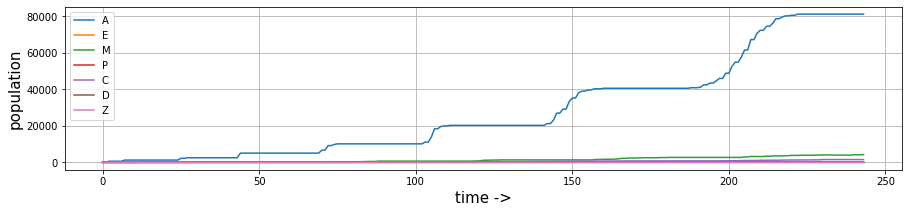

tag = 20090415_fkh-4_11D3b24_L2


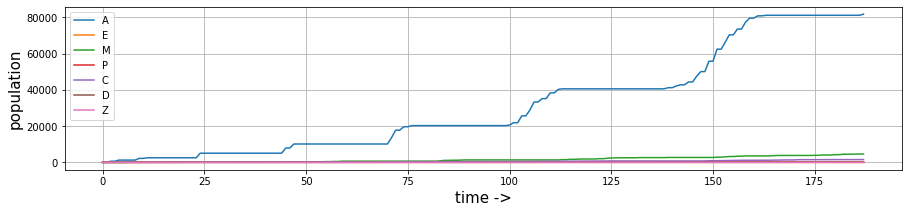

tag = 20080508_pha-4_3E3C5_1_L2


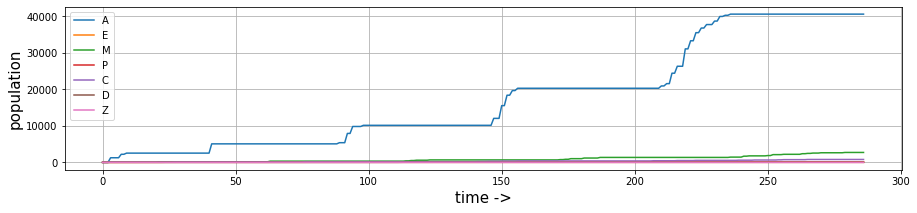

tag = 20070319_pha4_I1LBBB


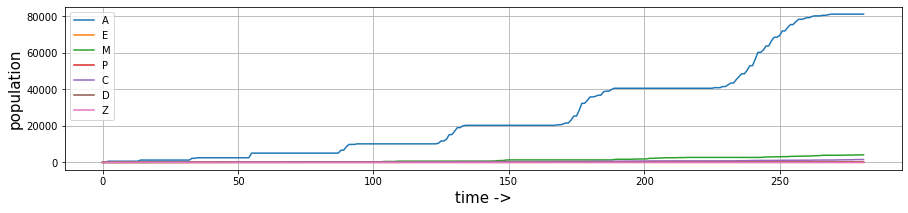

tag = 20080902_ceh-36B4_L1


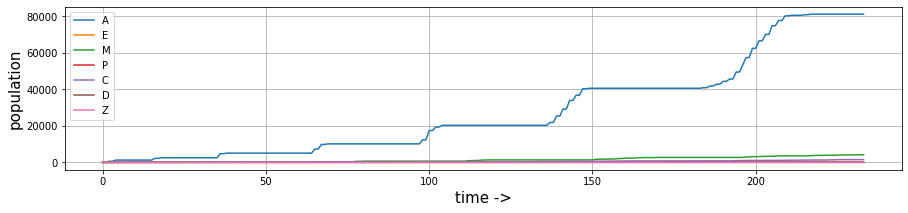

In [52]:
for tag in unique_tags[:5]:
    plot_time_series(tag)

## Plotting the time series populations for the first `unique_tag`



In [53]:
df_test = pd.read_csv("scaled_training_data.csv")

def generate_a_plot(look_for_tag, df_test):

    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)]
    
    data = scaler.inverse_transform(df_single_cell[['A', 'E', 'M', 'P', 'C', 'D', 'Z']].values)
    a_data = data[:,0]
    a_data = a_data[:len(os.listdir("frames/" + look_for_tag))-1]
    return a_data

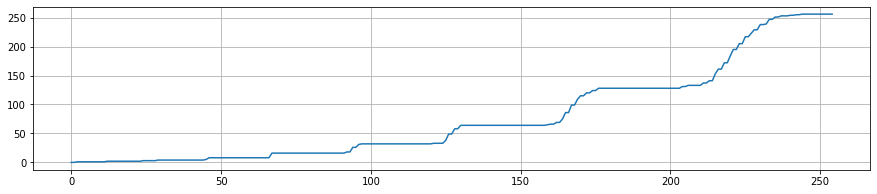

In [64]:
p = generate_a_plot( "20081010_ceh-14_8F2_14_L1", df_test)
plt.plot(p)
plt.grid()

## Plotting out all the tags 

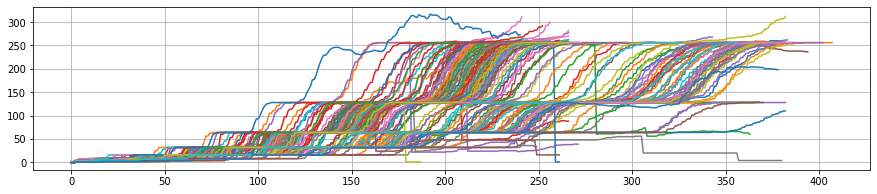

In [65]:
for tag in unique_tags:
    try:
        plt.plot(generate_a_plot(tag, df_test))
    except:
        pass
plt.grid()

## Finding "cliffs"

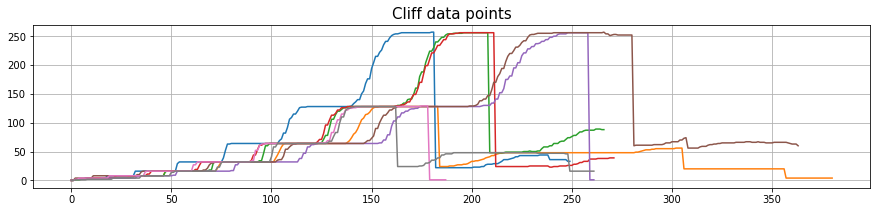

In [66]:
cliff_tags = []
for tag in unique_tags:
    try:
        pl =  generate_a_plot(tag, df_test)
    
        diffs = abs(np.diff(pl)) > 50   ## for deltas greater than 50 
        if True in diffs:
            cliff_tags.append(tag)
            plt.plot(pl)
    except:
        pass
plt.grid()
plt.title("Cliff data points", fontsize = 15)
plt.show()

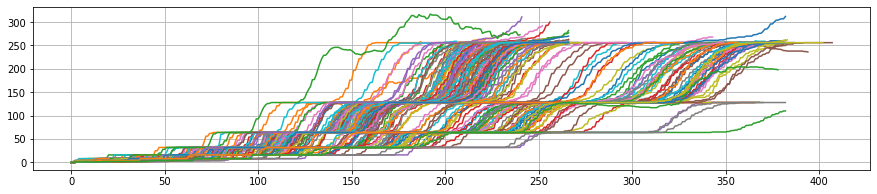

In [67]:
for tag in unique_tags:
    if tag in cliff_tags:
        pass
    else:
        try:
            pl = generate_a_plot(tag, df_test)
            plt.plot(pl)
        except:
            pass
plt.grid()

In [68]:
good_tags = []
for tag in unique_tags:
    if tag in cliff_tags:
        pass
    else:
        good_tags.append(tag)

In [69]:
clean_tags = np.array(good_tags)

pd.DataFrame(clean_tags , columns = ["clean_tags"]).to_csv("/content/clean_tags.csv", index = False)

## Preparing the new training data

In [70]:
def prepare_clean_df(look_for_tag, df_test  = df):
    df_single_cell = df_test[df_test['filenames'].str.contains(look_for_tag)].head(len(os.listdir("frames/" + look_for_tag))-1)
    return df_single_cell

In [71]:
dfs = []
for tag in clean_tags:
    dfs.append(prepare_clean_df(tag))

In [72]:
clean_df = pd.concat(dfs)
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55918 entries, 13130 to 12287
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filenames  55918 non-null  object
 1   A          55918 non-null  int64 
 2   E          55918 non-null  int64 
 3   M          55918 non-null  int64 
 4   P          55918 non-null  int64 
 5   C          55918 non-null  int64 
 6   D          55918 non-null  int64 
 7   Z          55918 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 3.8+ MB


In [31]:
clean_df.to_csv("/content/clean_training_data.csv")

In [75]:
len(clean_tags)

213

In [87]:
dfs = []
for tag in clean_tags[:213]: #change this
    dfs.append(prepare_clean_df(tag))

clean_df = pd.concat(dfs)
clean_df.info()

clean_df.to_csv("/content/epic_56k.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55918 entries, 13130 to 12287
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   filenames  55918 non-null  object
 1   A          55918 non-null  int64 
 2   E          55918 non-null  int64 
 3   M          55918 non-null  int64 
 4   P          55918 non-null  int64 
 5   C          55918 non-null  int64 
 6   D          55918 non-null  int64 
 7   Z          55918 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 3.8+ MB


In [88]:
clean_tags[:10]

array(['20081106_nhr-57_5_L1', '20090415_fkh-4_11D3b24_L2',
       '20080508_pha-4_3E3C5_1_L2', '20070319_pha4_I1LBBB',
       '20080902_ceh-36B4_L1', '20080923_lin-32_1_L1',
       '20080509_cnd-1_3C3_6yy_L2', '20090701_elt-6_RW10178_L1',
       '20091113_mel-28_2_L1', '20090609_pal-1_7A2_2_L2'], dtype='<U27')